<a href="https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Data analyze

In [3]:
import pandas as pd

train_data = pd.read_csv(tr_path)
test_data = pd.read_csv(tt_path)

In [4]:
train_data.iloc[:, 41:]

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0.814610,0.771356,25.648907,21.242063,84.644672,13.462475,36.519841,63.139094,23.835119,44.726055,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,0.838995,0.807766,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.655823,0.659976,25.265366,20.468897,91.011756,6.801897,32.727184,50.265694,15.188547,31.597793,...,15.090116,30.839219,7.849525,1.760094,14.617563,11.163213,18.742673,68.024690,38.920206,13.008853
2696,0.598352,0.602552,25.299465,20.756444,90.682057,7.152368,33.638563,50.050349,15.462823,31.656358,...,14.779264,30.617100,7.754800,1.780730,14.513419,11.281241,18.539741,67.855755,39.224244,12.725638
2697,0.586713,0.597559,25.271178,20.770195,90.866100,6.857209,33.959012,50.024971,15.090116,30.839219,...,14.961085,30.595194,7.744075,1.921828,14.160990,11.163526,18.702564,67.731162,38.740651,12.613441
2698,0.576435,0.595312,24.607461,20.176201,90.846126,6.851475,33.932384,49.885129,14.779264,30.617100,...,14.609582,30.420998,7.687974,1.992580,14.409427,11.330301,19.134697,67.795100,38.595125,12.477227


In [5]:
train_data.iloc[:, 41:].describe()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,...,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,...,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,...,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,...,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,...,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932258,43.997637,15.646480
75%,1.266849,1.302040,36.109114,30.238061,93.937119,11.582209,35.387315,58.866130,21.396971,41.659971,...,21.207162,41.508520,13.602566,2.730469,19.503419,14.214320,20.713638,69.719651,48.118283,22.535165
max,2.597732,2.625885,56.832289,51.550450,98.087160,18.552325,42.359074,65.673889,28.488220,50.606465,...,28.488220,50.606465,24.496711,8.162275,28.574091,18.715944,28.366270,77.701014,58.433600,40.959495


In [6]:
corr = train_data.iloc[:, 41:].corr().iloc[-1]
features = corr[abs(corr) > 0.4]
features_col = features.index.to_list()[:-1]
features_id = np.array([train_data.columns.to_list().index(i) for i in features_col]) - 1

print (features)
print ("\nfeatures' id:", features_id)

cli                   0.838504
ili                   0.830527
hh_cmnty_cli          0.879724
nohh_cmnty_cli        0.869938
shop                 -0.410430
public_transit       -0.448360
worried_finances      0.475462
tested_positive       0.981165
cli.1                 0.838224
ili.1                 0.829200
hh_cmnty_cli.1        0.879438
nohh_cmnty_cli.1      0.869278
shop.1               -0.412705
public_transit.1     -0.449079
worried_finances.1    0.480958
tested_positive.1     0.991012
cli.2                 0.835751
ili.2                 0.826075
hh_cmnty_cli.2        0.878218
nohh_cmnty_cli.2      0.867535
shop.2               -0.415130
public_transit.2     -0.450436
worried_finances.2    0.485843
tested_positive.2     1.000000
Name: tested_positive.2, dtype: float64

features' id: [40 41 42 43 47 51 56 57 58 59 60 61 65 69 74 75 76 77 78 79 83 87 92]


In [7]:
feats = [i for i in range(40)] + list(features_id)

In [8]:
min_level = train_data.iloc[:, 41:-1].min().values
max_level = train_data.iloc[:, 41:-1].max().values
mean_level = train_data.iloc[:, 41:-1].mean().values
std_level = train_data.iloc[:, 41:-1].std().values

# **Some Utilities**

You do not need to modify this part.

In [9]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [10]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False,
                 features_id = feats,
                 min_level = min_level,
                 max_level = max_level,
                 mean_level = mean_level,
                 std_level = std_level):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
            data[:, 40:93] = (data[:, 40:93] - min_level)/(max_level - min_level) # min-max normalization
#             data[:, 40:93] = (data[:, 40:93] - mean_level)/std_level              #gaussian normalization
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = features_id

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
#         self.data[:, 40:] = \
#             (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
#             / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [11]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [12]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        """ Calculate loss """
        loss = torch.sqrt(self.criterion(pred, target))
        # l2 = 0
        # for i in self.parameters():
        #     l2 += torch.sum(torch.pow(i, 2))
        # return loss + 0.01 * l2, loss  
        l1 = 0
        for i in self.parameters():
            l1 += torch.sum(abs(i))
        return loss + 0.0005 * l1, loss

# **Train/Dev/Test**

## **Training**

In [13]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_rmse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            rmse_l1_loss, rmse_loss = model.cal_loss(pred, y)  # compute loss
            rmse_l1_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            train_loss = rmse_loss.detach().cpu().item() #train loss value
            loss_record['train'].append(train_loss)

        # After each epoch, test your model on the validation (development) set.
        dev_rmse = dev(dv_set, model, device)
        if dev_rmse*0.998 + train_loss*0.002 < min_rmse:
            # Save model if your model improved
            min_rmse = dev_rmse*0.998 + train_loss*0.002
            print('epoch = {:4d}, training loss = {:.4f}, validation loss = {:.4f}, weighted average loss = {:.4f}'
                .format(epoch + 1, train_loss, dev_rmse, min_rmse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_rmse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_rmse, loss_record

## **Validation**

In [14]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            rmse_l1_loss, rmse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += rmse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [15]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [16]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 8000,                # maximum number of epochs
    'batch_size': 130,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 5e-4,                 # learning rate of SGD
        'momentum': 0.9,              # momentum for SGD
        'weight_decay': 5e-4         #weight decay for SGD
    },
    'early_stop': 800,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [17]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 63)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 63)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 63)


In [18]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [19]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

epoch =    1, training loss = 18.0146, validation loss = 17.7022, weighted average loss = 17.7028
epoch =    2, training loss = 17.7474, validation loss = 17.5910, weighted average loss = 17.5913
epoch =    3, training loss = 17.8267, validation loss = 17.4585, weighted average loss = 17.4592
epoch =    4, training loss = 18.6979, validation loss = 17.3065, weighted average loss = 17.3093
epoch =    5, training loss = 17.1373, validation loss = 17.1280, weighted average loss = 17.1280
epoch =    6, training loss = 16.8872, validation loss = 16.9101, weighted average loss = 16.9100
epoch =    7, training loss = 17.7745, validation loss = 16.6326, weighted average loss = 16.6349
epoch =    8, training loss = 17.1241, validation loss = 16.2707, weighted average loss = 16.2724
epoch =    9, training loss = 14.6124, validation loss = 15.7838, weighted average loss = 15.7815
epoch =   10, training loss = 13.9781, validation loss = 15.1200, weighted average loss = 15.1177
epoch =   11, traini

epoch =   92, training loss = 1.4158, validation loss = 1.4356, weighted average loss = 1.4356
epoch =   93, training loss = 1.4008, validation loss = 1.4279, weighted average loss = 1.4278
epoch =   94, training loss = 1.3669, validation loss = 1.4218, weighted average loss = 1.4217
epoch =   95, training loss = 1.2738, validation loss = 1.4128, weighted average loss = 1.4126
epoch =   96, training loss = 1.4385, validation loss = 1.4079, weighted average loss = 1.4079
epoch =   97, training loss = 1.4575, validation loss = 1.4025, weighted average loss = 1.4026
epoch =   98, training loss = 1.4607, validation loss = 1.4004, weighted average loss = 1.4006
epoch =   99, training loss = 1.4509, validation loss = 1.3907, weighted average loss = 1.3908
epoch =  100, training loss = 1.3691, validation loss = 1.3880, weighted average loss = 1.3880
epoch =  101, training loss = 1.4349, validation loss = 1.3824, weighted average loss = 1.3825
epoch =  102, training loss = 1.4493, validation l

epoch =  216, training loss = 1.2525, validation loss = 1.1405, weighted average loss = 1.1408
epoch =  218, training loss = 1.0534, validation loss = 1.1373, weighted average loss = 1.1372
epoch =  221, training loss = 1.1156, validation loss = 1.1335, weighted average loss = 1.1335
epoch =  223, training loss = 1.0572, validation loss = 1.1311, weighted average loss = 1.1309
epoch =  225, training loss = 1.0764, validation loss = 1.1283, weighted average loss = 1.1281
epoch =  227, training loss = 1.1629, validation loss = 1.1278, weighted average loss = 1.1279
epoch =  231, training loss = 1.1767, validation loss = 1.1215, weighted average loss = 1.1216
epoch =  232, training loss = 1.1996, validation loss = 1.1214, weighted average loss = 1.1216
epoch =  233, training loss = 0.9878, validation loss = 1.1204, weighted average loss = 1.1201
epoch =  235, training loss = 0.9801, validation loss = 1.1182, weighted average loss = 1.1179
epoch =  236, training loss = 1.1549, validation l

epoch =  530, training loss = 0.8908, validation loss = 0.9921, weighted average loss = 0.9919
epoch =  534, training loss = 0.8555, validation loss = 0.9915, weighted average loss = 0.9913
epoch =  550, training loss = 0.8710, validation loss = 0.9898, weighted average loss = 0.9896
epoch =  557, training loss = 0.9584, validation loss = 0.9891, weighted average loss = 0.9891
epoch =  566, training loss = 1.0242, validation loss = 0.9858, weighted average loss = 0.9859
epoch =  569, training loss = 1.0134, validation loss = 0.9849, weighted average loss = 0.9849
epoch =  576, training loss = 0.8974, validation loss = 0.9848, weighted average loss = 0.9846
epoch =  582, training loss = 1.0517, validation loss = 0.9827, weighted average loss = 0.9828
epoch =  588, training loss = 0.8515, validation loss = 0.9828, weighted average loss = 0.9825
epoch =  592, training loss = 0.8253, validation loss = 0.9821, weighted average loss = 0.9817
epoch =  603, training loss = 0.9941, validation l

epoch = 1122, training loss = 0.9835, validation loss = 0.9307, weighted average loss = 0.9308
epoch = 1142, training loss = 0.9168, validation loss = 0.9295, weighted average loss = 0.9294
epoch = 1156, training loss = 0.8891, validation loss = 0.9294, weighted average loss = 0.9293
epoch = 1157, training loss = 0.8642, validation loss = 0.9288, weighted average loss = 0.9287
epoch = 1164, training loss = 0.9776, validation loss = 0.9281, weighted average loss = 0.9282
epoch = 1178, training loss = 0.8728, validation loss = 0.9281, weighted average loss = 0.9280
epoch = 1186, training loss = 0.8561, validation loss = 0.9278, weighted average loss = 0.9276
epoch = 1188, training loss = 0.9529, validation loss = 0.9271, weighted average loss = 0.9272
epoch = 1207, training loss = 1.0715, validation loss = 0.9255, weighted average loss = 0.9258
epoch = 1212, training loss = 0.9579, validation loss = 0.9253, weighted average loss = 0.9254
epoch = 1214, training loss = 0.7583, validation l

epoch = 2552, training loss = 0.8558, validation loss = 0.9001, weighted average loss = 0.9000
epoch = 2594, training loss = 0.8236, validation loss = 0.9001, weighted average loss = 0.9000
epoch = 2600, training loss = 0.8917, validation loss = 0.8998, weighted average loss = 0.8998
epoch = 2702, training loss = 0.8237, validation loss = 0.8996, weighted average loss = 0.8995
epoch = 2732, training loss = 0.6978, validation loss = 0.8998, weighted average loss = 0.8994
epoch = 2810, training loss = 0.9376, validation loss = 0.8992, weighted average loss = 0.8993
epoch = 2897, training loss = 0.9813, validation loss = 0.8990, weighted average loss = 0.8991
epoch = 2955, training loss = 0.8986, validation loss = 0.8986, weighted average loss = 0.8986
epoch = 2963, training loss = 0.8666, validation loss = 0.8984, weighted average loss = 0.8984
epoch = 3378, training loss = 0.7819, validation loss = 0.8983, weighted average loss = 0.8981
epoch = 3422, training loss = 0.7608, validation l

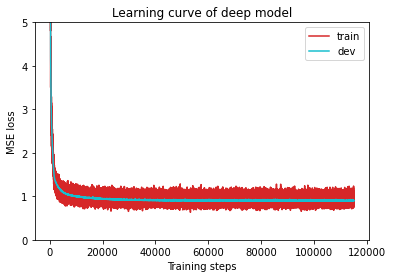

In [20]:
plot_learning_curve(model_loss_record, title='deep model')

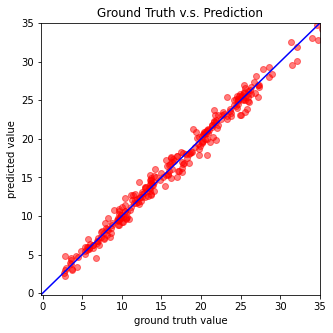

In [21]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [22]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
